In [1]:
sc.uninstall_package('pip')
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python") #Install opencv-python 
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import product
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, asc

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1694977619391_0003,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling pip-9.0.1:
  Successfully uninstalled pip-9.0.1

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)

  Using cached opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)


  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached Pillow-9.5.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)




[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /tmp/1694981794936-0/bin/python -m pip install --

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

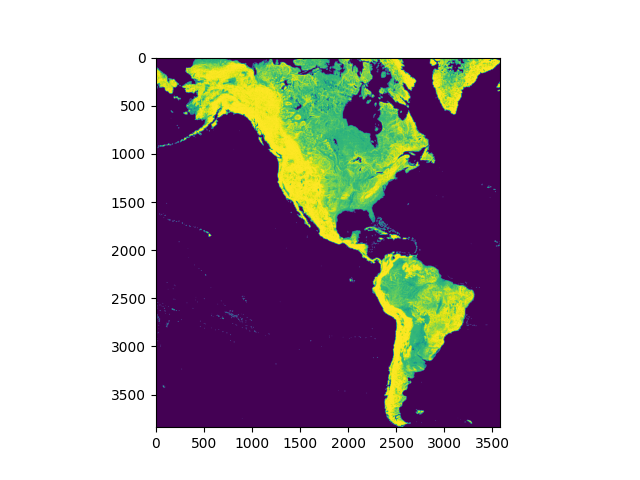

In [17]:
# Function to transform geographical coordinates to tile coordinates
def transform_geo_to_tile(lat, lon):
    lat_rad = math.radians(lat)
    zoom = 32.0
    x_tile = int((lon + 180.0) / 360.0 * zoom)
    y_tile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * zoom)
    return (x_tile, y_tile)

# Function to transform tile coordinates to geographical coordinates
def transform_tile_to_geo(x, y):
    zoom = 32.0
    lon = x / zoom * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y / zoom)))
    lat = math.degrees(lat_rad)
    return (lat, lon)

# Function to generate a list of URLs for tile retrieval at a specified zoom level
def generate_tiles(lat1, lon1, lat2, lon2):
    min_lat, min_lon = min(lat1, lat2), min(lon1, lon2)
    max_lat, max_lon = max(lat1, lat2), max(lon1, lon2)
    
    x_min, y_min = transform_geo_to_tile(max_lat, min_lon)
    x_max, y_max = transform_geo_to_tile(min_lat, max_lon)
    
    tiles = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            tiles.append(f"s3://elevation-tiles-prod//terrarium/{5}/{x}/{y}.png")
    
    return tiles, (x_max - x_min) + 1, (y_max - y_min) + 1


# Function to display a composite map from a set of tiles
def display_output_map(tile_set, x_count, y_count):
    tile_columns = [np.concatenate(tile_set[i * y_count: (i + 1) * y_count], axis=0) for i in range(x_count - 1)]
    output_map = np.concatenate(tile_columns, axis=1)
    plt.clf()
    plt.imshow(output_map)

# Function to calculate elevation from pixel data
def calc_height_increase(pixel_data):
    (B, G, R) = cv2.split(pixel_data)
    elevation = (R * 256.0 + G + B / 256.0) - 32768.0
    elevation = np.where(elevation > 0, elevation, 0)
    return elevation

# Function to generate elevation thresholds
def generate_elevation_thresholds(pixel_data):
    parallel_data = spark.sparkContext.parallelize(pixel_data)
    avg_values = parallel_data.map(lambda elem: cv2.mean(elem)).sortBy(lambda elem: elem[0]).collect()

    total_count = len(avg_values)
    thresholds = []

    percentage_groups = [
        ("95% - 100%", int(95 * total_count / 100)),
        ("80% - 95%", int(80 * total_count / 100)),
        ("60% - 80%", int(60 * total_count / 100)),
        ("45% - 60%", int(45 * total_count / 100)),
        ("30% - 45%", int(30 * total_count / 100)),
        ("15% - 30%", int(15 * total_count / 100))
    ]

    for label, index in percentage_groups:
        threshold_value = avg_values[index][0]
        thresholds.append(threshold_value)
        print(f"{label}: {threshold_value}")

    return thresholds

# Function to apply elevation thresholds
def apply_elevation_thresholds(input_array, thresholds):
    output_array = input_array.copy()

    output_array = np.where(input_array >= thresholds[0], 0, output_array)
    output_array = np.where((thresholds[0] > input_array) & (input_array >= thresholds[1]), 1, output_array)
    output_array = np.where((thresholds[1] > input_array) & (input_array >= thresholds[2]), 2, output_array)
    output_array = np.where((thresholds[2] > input_array) & (input_array >= thresholds[3]), 3, output_array)
    output_array = np.where((thresholds[3] > input_array) & (input_array >= thresholds[4]), 4, output_array)
    output_array = np.where((thresholds[4] > input_array) & (input_array >= thresholds[5]), 5, output_array)
    output_array = np.where((thresholds[5] > input_array), 6, output_array)

    return output_array

# Function to apply color mapping to pixel data
def apply_color_mapping(pixel_data, thresholds):
    parallel_data = spark.sparkContext.parallelize(pixel_data)
    return parallel_data.map(lambda element: apply_elevation_thresholds(element, thresholds)).collect()

# Function to extract X coordinate from file path
def extract_x(filepath):
    result = int(filepath.split("/")[5])
    return result

# Function to extract Y coordinate from file path
def extract_y(filepath):
    result = filepath.split("/")[6]
    result = int(result.split(".")[0])
    return result

# Main pipeline function
def run_image_processing_pipeline():
    coords = [-50.0, -177.0, 70.0, -20.0]
    
    tile_data, x_span, y_span = generate_tiles(*coords)
    
    image_dataframe = spark.read.format("image").load(tile_data)
    refined_image_data = image_dataframe.select("image.origin", "image.data")
    
    extract_x_coord = F.udf(extract_x, IntegerType())
    extract_y_coord = F.udf(extract_y, IntegerType())

    refined_image_data = refined_image_data.withColumn("x_idx", extract_x_coord("origin"))
    refined_image_data = refined_image_data.withColumn("y_idx", extract_y_coord("origin"))
    refined_image_data = refined_image_data.orderBy(col("x_idx").asc(), col("y_idx").asc())
    
    pixel_data = refined_image_data.select("data")
    
    pixel_data_rdd = pixel_data.rdd.map(lambda img: np.reshape(img, (256, 256, 3)))
    elevation_data = pixel_data_rdd.map(calc_height_increase)
    
    gradientX = elevation_data.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 1, 0))
    gradientY = elevation_data.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 0, 1))

    grad_x = np.asarray(gradientX.take(gradientX.count()))
    grad_y = np.asarray(gradientY.take(gradientY.count()))

    gradient_magnitude = 1 - np.sqrt(grad_x**2 + grad_y**2)

    elevation_thresholds = generate_elevation_thresholds(gradient_magnitude)
  
    color_mapped = apply_color_mapping(gradient_magnitude, elevation_thresholds)
    
    display_output_map(color_mapped, x_span, y_span)
    plt.imsave('color_mapped_output.png', color_mapped)

run_image_processing_pipeline()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

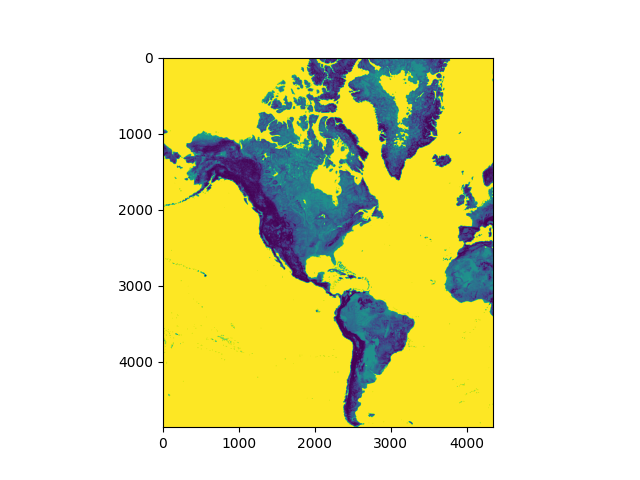